# <b> Introduction </b>

These data come from a lab session done this semester in which students completed a baseline countermovement vertical jump (CMJ), <u> a 15-second Wingate test againts 7.5% of their body mass</u>, and then another CMJ. Goal of the lab was to introduce students to experimental designs by measuring somtehing prior to and after (CMJ perofrmance) some kind of intervention, in this case the intervention was the Wingate test. As well as introduce the energy systems

For their lab reports, students were given some discrete variables all calculated via the Hawkin force plates such as:
<ul>
    <li> <i> Jump height (cm) via impulse-momentum. </i>
    <li> <i> Modified reactive strength index (AU). </i>
</ul>

For my own purposes of learning and improving my skills as a Python coder, I choose to use [the spm1d package](https://spm1d.org/index.html) for Statistical Parameteric Mapping (SPM) of the CMJ force time curves prior to and after the Wingate. This is a package I have been wanting to experiment with for a while. Since in exercise and sports science, we spend so much time on discrete (peaks, means, etc.) variables but collect much more data than we actually analyze. SPM allows for the analysis of the entire force-time curve. 

In [ ]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tkinter.filedialog import askdirectory
import spm1d

# defining plot theme. 
custom_theme = {"axes.spines.right": False, "axes.spines.top": False,
                "axes.titlelocation": "center", "axes.titley": 1,
                "font.weight":"bold", "axes.titlesize": "x-large", "axes.labelsize": "x-large",
                "axes.titleweight": "bold", "axes.labelweight": 'bold'}

plt.rcParams.update({**custom_theme})

## <b> Data Loading </b>
Select the directory where the files are stored (clone the git repo if necessary). Print the file names and check the number of files that will be analyzed. 

In [5]:
dir_to_read = askdirectory(title = 'Select Directory to Read CMJ Files')
files_to_read = os.listdir(dir_to_read)

for file_to_print in files_to_read:
    print(file_to_print[:-4])
print(f'\nThere are {len(files_to_read)} files.')

001-POST
001-PRE
002-POST
002-PRE
003-POST
003-PRE
004-POST
004-PRE
005-POST
005-PRE
006-POST
006-PRE
007-POST
007-PRE
008-POST
008-PRE
009-POST
009-PRE

There are 18 files.


## <b> Custom Function for Analyzing CMJ Force Time Arrays
Next, I'm writing a custom function to read the force arrays, identify the indices we need, crop the arrays to those indices, and then interpolate the data to 101 data points (0-100% of the CMJ phase of interest).</b>

Specifically, the CMJ force time data will be cropped from the point of movement initation ('start_move') to takeoff ('takeoff').

The index identification portion of the below code has been adapted from [Merrigan et al.](https://journals.lww.com/nsca-jscr/fulltext/2022/09000/analyzing_force_time_curves__comparison_of.4.aspx). 


In [ ]:
# This is a custom function to read, analyze (find the indices of interest), crop, and interpolate the CMJ data
sf = 1000 # Hawkin sampling frequency = 1000 Hz

def read_and_crop_and_interpolate_cmj(file_path):
    full_data = pd.read_csv(file_path)
    fz_total = full_data.iloc[:,0] # data are stored in the first column from how I set it up to export from R's {HawkinR} package.     
    
    # calculate baseline fz ('weighing phase') - mean of first 1-second of data.
    bw_mean = fz_total[0:1000].mean()
    
    # calculate baseline standard deviation for determination of movement start.
    bw_sd = fz_total[0:1000].std()
    
    # convert body weight in Newtons to body mass in kilograms. 
    bodymass = bw_mean/9.81

    # this determines when movement begins
    start_move = 20 # temporarily assign the start move index to the 20th index of the array
    
    # while loop to identify the point at which the fz_total array deviates from the mean by 5 standard deviations
    while fz_total[start_move] > (bw_mean - (bw_sd * 5)):
        start_move = start_move + 1

    # backtrack start_move to within 1 standard deviation of the baseline force
    while fz_total[start_move] < (bw_mean - bw_sd):
        start_move = start_move -1
    
    # identify takeoff index of original dataframe as when force drops below 30 N    
    takeoff = start_move # first say that takeoff index = start_move index
    while fz_total[takeoff] > 30:
        takeoff = takeoff + 1
        
    # crop the array from start movement to takeoff
    cropped_fz_total_original = fz_total[start_move:takeoff]
    
    # normalize to bodymass in kilos so N/kg is comparable between subjects
    cropped_fz_normalized = cropped_fz_total_original/bodymass
    
    # interpolate to 101 datapoints
    original_data = np.linspace(0, len(cropped_fz_normalized)-1, len(cropped_fz_normalized))
    interpolated_indices = np.linspace(0, len(cropped_fz_normalized)-1, 101)
    force_interpolated = np.interp(interpolated_indices, original_data, cropped_fz_normalized)
    
    # return the cropped, normalized and interpolated array
    return(force_interpolated)

<b> We just wrote that custom function, now apply it in a for loop over the files we need to read, crop, normalize, and interpolate. </b>

For sanity's check as well, we will be creating a Spaghetti plot of all the arrays in the loop.

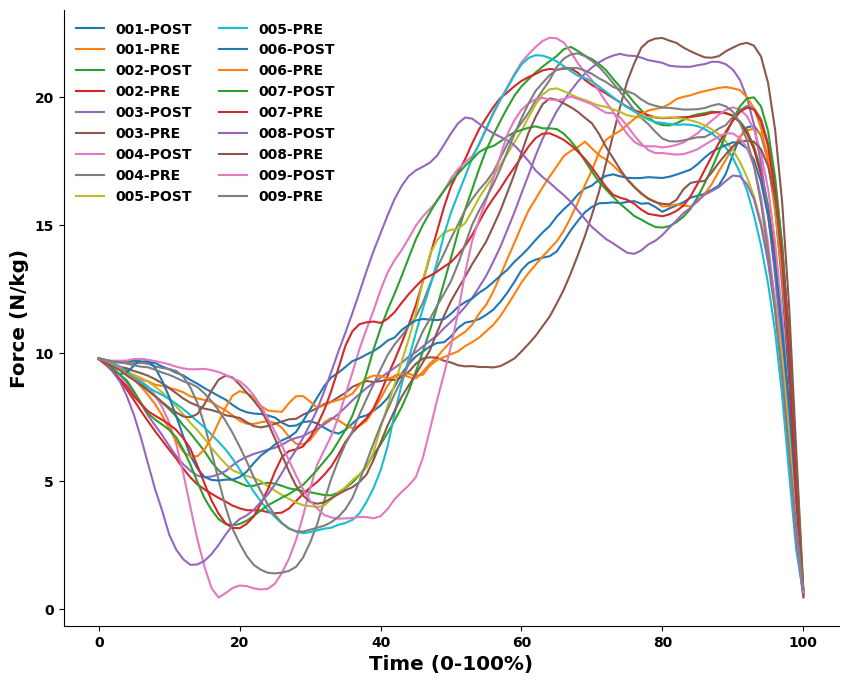

In [ ]:
# preallocate a panda's dataframe to store the data in
data_to_save = pd.DataFrame()

# initalize a plot
plt.figure(figsize = (10, 8))

# for loop
for file_name in files_to_read:
    file_path_of_choice = os.path.join(dir_to_read, file_name) # get the full file path by joining the directory we selected with the filename
    
    # apply the function
    cleaned_and_interpolated_data = read_and_crop_and_interpolate_cmj(file_path=file_path_of_choice)
    
    # remove the .csv from the filename
    base_file_name = file_name[:-4]
    
    # append the dataframe with the values we just generated...
    data_to_save[base_file_name] = cleaned_and_interpolated_data
    
    # plot the data for sanity checks. always. 
    plt.plot(cleaned_and_interpolated_data, label = base_file_name)

# outside of the loop, figure theme settings
plt.legend(loc = 'upper left', frameon = False, ncol = 2)
plt.ylabel('Force (N/kg)')
plt.xlabel('Time (0-100%)');

<b> Things look good! Let's check the dataframe now.

In [14]:
data_to_save.head(10)

,001-POST,001-PRE,002-POST,002-PRE,003-POST,003-PRE,004-POST,004-PRE,005-POST,005-PRE,006-POST,006-PRE,007-POST,007-PRE,008-POST,008-PRE,009-POST,009-PRE
0,9.775837,9.779228,9.806930,9.797101,9.766499,9.774600,9.764290,9.782109,9.785691,9.796256,9.784046,9.812087,9.777619,9.769693,9.776079,9.769985,9.787597,9.790969
1,9.723279,9.632452,9.711841,9.573125,9.586303,9.651317,9.713698,9.706181,9.638169,9.730729,9.568994,9.680602,9.599484,9.542988,9.578110,9.618327,9.708962,9.740845
2,9.654953,9.503170,9.592608,9.284729,9.387806,9.571007,9.652228,9.656068,9.515233,9.608194,9.321110,9.513616,9.392452,9.305186,9.264958,9.474439,9.703943,9.674681
3,9.653201,9.373888,9.479038,8.931616,9.158337,9.457586,9.466049,9.629493,9.375905,9.413579,9.176647,9.358134,9.160283,8.990495,8.894216,9.326666,9.703943,9.647948
4,9.674224,9.234810,9.333574,8.567766,8.849328,9.404750,9.252803,9.617597,9.261165,9.248452,9.248878,9.168467,8.928114,8.701962,8.307507,9.122489,9.710635,9.589135
5,9.701380,9.080337,9.078117,8.159777,8.443183,9.299079,9.060426,9.604943,9.150523,9.029592,9.513179,8.978800,8.504945,8.307211,7.580421,8.944788,9.770866,9.523639
6,9.670721,8.951055,8.831900,7.736877,8.022255,9.216655,8.909535,9.617597,9.031685,8.855291,9.777480,8.686574,8.052879,8.013130,6.680561,8.744928,9.770866,9.471510
7,9.653201,8.904520,8.547678,7.334554,7.561910,9.114859,8.688700,9.583177,8.884162,8.671161,9.723306,8.363777,7.635648,7.727767,5.672717,8.532549,9.737404,9.446113
8,9.611155,8.764567,8.308765,6.946547,7.176881,8.982065,8.338097,9.478395,8.687465,8.504067,9.429456,8.004822,7.405656,7.554965,4.679272,8.324200,9.687212,9.353885
9,9.478883,8.720657,8.060014,6.587469,6.801003,8.823558,7.894277,9.419677,8.466180,8.368427,8.918913,7.567305,7.210301,7.391674,3.844202,8.088511,9.631163,9.239601


<b> Check the shape of the dataframe we created. We should have 18 columns (9 subjects, 2 conditions = 18) and 101 rows (101 datapoints).

In [22]:
print(f'There are {data_to_save.shape[1]} columns. And there are {data_to_save.shape[0]} rows.')

There are 18 columns. And there are 101 rows.


# <b> Data Cleaning </b>
<b> The next chunk will create the two arrays we will be analyzing in spm1d at - PRE vs. POST.</b>

<ol>
<li> First, filter the dataframes into post_df and pre_df based on column names
<li> Then transpose the dataframes into a J x Q matrix (subjects [rows] X nodes/points per trial [columns])
<li> Lastly, transfer the dataframe into an array for ease. 


In [9]:
post_df = data_to_save.loc[:, data_to_save.columns.str.contains('POST')]
pre_df = data_to_save.loc[:, data_to_save.columns.str.contains('PRE')]

post_transpose = post_df.T
pre_transpose = pre_df.T

pre_ft = np.array(post_transpose)
post_ft = np.array(pre_transpose)

<b> Going to arrange the data so we can plot it as mean +/- SD for PRE and POST in the next code block. 

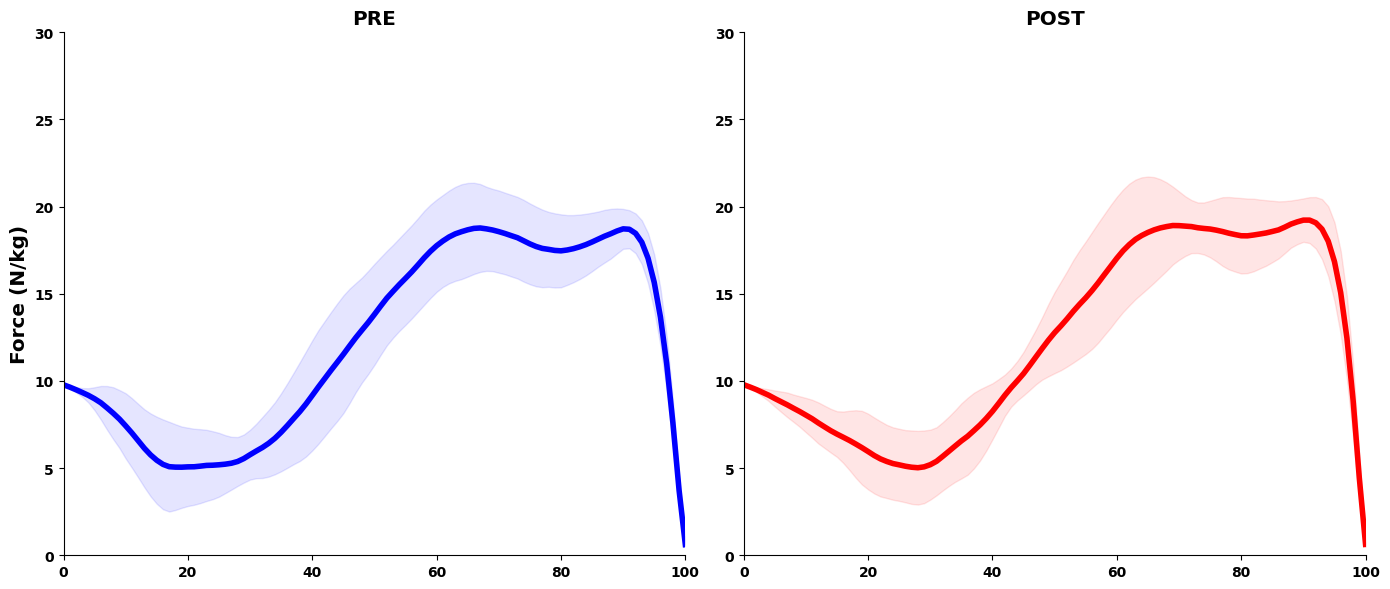

In [12]:
pre_mean = pre_ft.mean(axis = 0)
pre_sd = pre_ft.std(axis = 0)

post_mean = post_ft.mean(axis = 0)
post_sd = post_ft.std(axis = 0)

# make an x values
x_vals = np.arange(101)

# plot mean and SD for fun
plt.figure(figsize = (14, 6))

# plt.subplot reminder plt.subplot(rows, columns, plot index)
plt.subplot(1, 2, 1)
plt.plot(x_vals, pre_mean, color = 'blue', linewidth = 4)
plt.fill_between(x_vals, pre_mean - pre_sd, pre_mean + pre_sd, color = 'blue', alpha = 0.1)
plt.xlim(0, 100)
plt.ylim(0, 30)
plt.ylabel('Force (N/kg)')
plt.title('PRE')

# plot the post data
# plt.subplot reminder plt.subplot(rows, columns, plot index)
plt.subplot(1, 2, 2)
plt.plot(x_vals, post_mean, color = 'red', linewidth = 4)
plt.fill_between(x_vals, post_mean - post_sd, post_mean + post_sd, color = 'red', alpha = 0.1)
plt.xlim(0, 100)
plt.ylim(0, 30)
plt.title('POST')
plt.tight_layout()

# <b> Running the SPM1D analysis. </b>
Now, this next code block will run the spm1d analyses.

In [51]:
t = spm1d.stats.ttest_paired(pre_ft, post_ft)
t

SPM{t}
   SPM.z      :  (1x101) test stat field
   SPM.df     :  (1, 8)
   SPM.fwhm   :  4.15726
   SPM.resels :  (1, 24.05429)



<b> Return the inferential stats of the SPM.

In [52]:
alpha = 0.05
ti = t.inference(alpha = alpha)
ti

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 8)
   SPM.fwhm      :  4.15726
   SPM.resels    :  (1, 24.05429)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  5.56250
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()



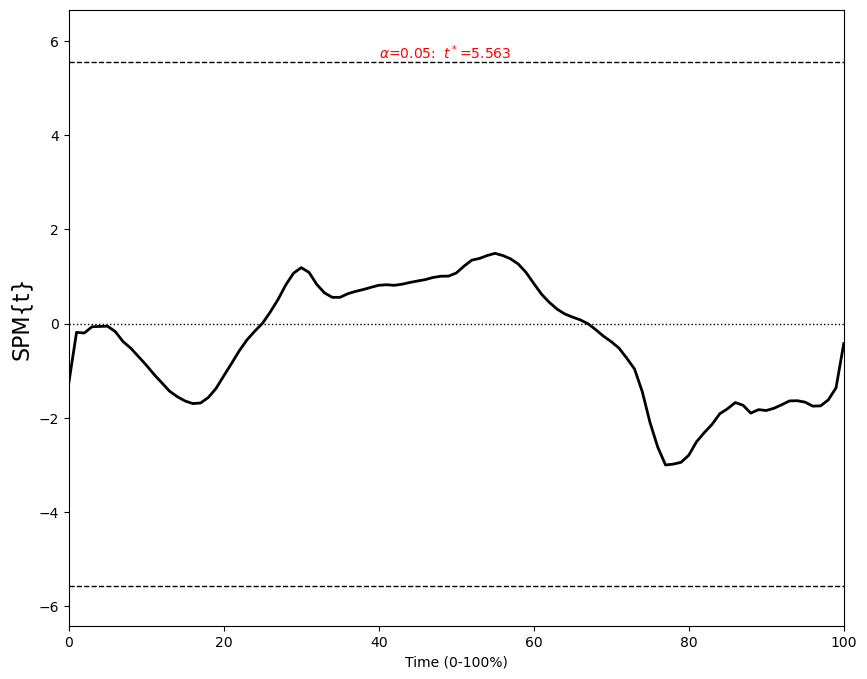

In [58]:
plt.figure(figsize = (10,8))
ti.plot()
ti.plot_threshold_label()
plt.xlabel('Time (0-100%)');